Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_text()`).”


[1] "Det genererade cirkulära stapeldiagrammet visualiserar fördelningen av värden för olika grupper över flera observationer.Genom att använda denna cirkulära layout kan man tydligt jämföra fördelningen av värden mellan olika grupper och observationer runt om i cirkeln. Det ger också en estetiskt tilltalande presentation av data som kan vara mer engagerande och lätt att förstå än traditionella stapeldiagram.Varje stapel representerar värdet för en specifik observation (eller individ) inom en viss grupp. Höjden på staplarna motsvarar värdet för den observationen. Varje stapel är färgkodad enligt vilken observationstyp den tillhör. Färgerna ger en visuell identifiering av vilken observationstyp varje stapel representerar. Varje stapel har dessutom en etikett som visar namnet på den individ som observationen representerar. Etiketterna är placerade ovanpå staplarna och är vinklade för att vara lättlästa längs cirkeln. Baslinjer och skalor längs cirkeln används för att indikera gruppernas gränser och värdena längs cirkeln. Detta ger en referenspunkt för att förstå varje grupp och dess relativa storlek längs cirkeln."

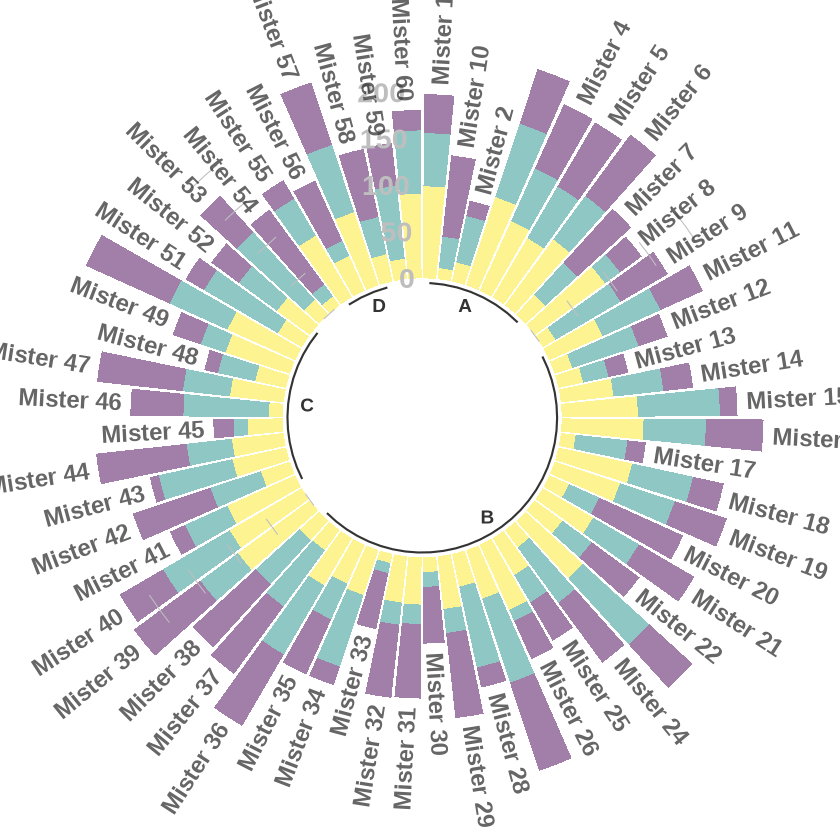

In [2]:
# ***********************************************************************************************
# Titel: Exempel på diagramtyper i R - CIRKULÄRT STAPELDIAGRAM 
# Beskrivning: Illustrera exempel med diagramtyper i R
# Skapad av: Frank Weideskog(frank.weideskog@scb.se), ID: SCBFRWE
# 2024-06-17 (SCBFRWE):En första version 
#*************************************************************************************************
# Rensar minnet i R
rm(list=ls())				
# ************************************************************************************************
#Installerar/aktiverar relevanta R-paket (R-packages):
suppressMessages({
  install.packages("tidyverse")
  library(tidyverse)
  install.packages("viridis")
  library(viridis)
  install.packages("dplyr")
  library(dplyr)
  })   
# ************************************************************************************************

# Cirkulärt stapeldiagram

# Dölj varningsmeddelanden och meddelanden vid start av paket
  suppressMessages({
    #Installerar relevanta R-paket (R-packages):
    install.packages("tidyverse")
    library(tidyverse)
    install.packages("viridis")
    library(viridis)
  })

# Create dataset
data <- data.frame(
  individual=paste( "Mister ", seq(1,60), sep=""),
  group=c( rep('A', 10), rep('B', 30), rep('C', 14), rep('D', 6)) ,
  value1=sample( seq(10,100), 60, replace=T),
  value2=sample( seq(10,100), 60, replace=T),
  value3=sample( seq(10,100), 60, replace=T)
)

# Transform data in a tidy format (long format)
data <- data %>% gather(key = "observation", value="value", -c(1,2)) 

# Set a number of 'empty bar' to add at the end of each group
empty_bar <- 2
nObsType <- nlevels(as.factor(data$observation))
to_add <- data.frame( matrix(NA, empty_bar*nlevels(data$group)*nObsType, ncol(data)) )
colnames(to_add) <- colnames(data)
to_add$group <- rep(levels(data$group), each=empty_bar*nObsType )
data <- rbind(data, to_add)
data <- data %>% arrange(group, individual)
data$id <- rep( seq(1, nrow(data)/nObsType) , each=nObsType)

# Get the name and the y position of each label
label_data <- data %>% group_by(id, individual) %>% summarize(tot=sum(value), .groups = "drop")
label_data <- label_data %>% na.omit()

number_of_bar <- nrow(label_data)
angle <- 90 - 360 * (label_data$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_data$hjust <- ifelse( angle < -90, 1, 0)
label_data$angle <- ifelse(angle < -90, angle+180, angle)

# prepare a data frame for base lines
base_data <- data %>% 
  group_by(group) %>% 
  summarize(start=min(id), end=max(id) - empty_bar) %>% 
  rowwise() %>% 
  mutate(title=mean(c(start, end)))

# prepare a data frame for grid (scales)
grid_data <- base_data
grid_data$end <- grid_data$end[ c( nrow(grid_data), 1:nrow(grid_data)-1)] + 1
grid_data$start <- grid_data$start - 1
grid_data <- grid_data[-1,]

# Make the plot
p <- ggplot(data) +      
  
  # Add the stacked bar
  geom_bar(aes(x=as.factor(id), y=value, fill=observation), stat="identity", alpha=0.5) +
  scale_fill_viridis(discrete=TRUE) +
  
  # Add a val=100/75/50/25 lines. I do it at the beginning to make sur barplots are OVER it.
  geom_segment(data=grid_data, aes(x = end, y = 0, xend = start, yend = 0), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 50, xend = start, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 100, xend = start, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 150, xend = start, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 200, xend = start, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  
  # Add text showing the value of each 100/75/50/25 lines
  ggplot2::annotate("text", x = rep(max(data$id),5), y = c(0, 50, 100, 150, 200), label = c("0", "50", "100", "150", "200") , color="grey", size=6 , angle=0, fontface="bold", hjust=1) +
  
  ylim(-150,max(label_data$tot, na.rm=T)) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm") 
  ) +
  coord_polar() +
  
  # Add labels on top of each bar
  geom_text(data=label_data, aes(x=id, y=tot+10, label=individual, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Add base line information
  geom_segment(data=base_data, aes(x = start, y = -5, xend = end, yend = -5), colour = "black", alpha=0.8, size=0.6 , inherit.aes = FALSE )  +
  geom_text(data=base_data, aes(x = title, y = -18, label=group), hjust=c(1,1,0,0), colour = "black", alpha=0.8, size=4, fontface="bold", inherit.aes = FALSE) 

p

text<- 'Det genererade cirkulära stapeldiagrammet visualiserar fördelningen av värden för olika grupper över flera observationer.Genom att använda denna cirkulära layout kan man tydligt jämföra fördelningen av värden mellan olika grupper och observationer runt om i cirkeln. Det ger också en estetiskt tilltalande presentation av data som kan vara mer engagerande och lätt att förstå än traditionella stapeldiagram.Varje stapel representerar värdet för en specifik observation (eller individ) inom en viss grupp. Höjden på staplarna motsvarar värdet för den observationen. Varje stapel är färgkodad enligt vilken observationstyp den tillhör. Färgerna ger en visuell identifiering av vilken observationstyp varje stapel representerar. Varje stapel har dessutom en etikett som visar namnet på den individ som observationen representerar. Etiketterna är placerade ovanpå staplarna och är vinklade för att vara lättlästa längs cirkeln. Baslinjer och skalor längs cirkeln används för att indikera gruppernas gränser och värdena längs cirkeln. Detta ger en referenspunkt för att förstå varje grupp och dess relativa storlek längs cirkeln.'
text